# Apply Pretrained Neural Networks on new Task
* Author: Johannes Maucher
* Last Update: 04.11.2020

## What you will learn
* Download and integrate deep neural network ([VGG-16](https://arxiv.org/pdf/1409.1556.pdf)), which has been trained on ImageNet Dataset
* Extract the feature-extractor part of this network, freeze the weights of this part, and define a new classifier-network on top of the pre-trained feature extractor.
* Train the new network (only the new classifier part) for the task of differentiating x-ray pictures of healthy lungs from x-ray pictures of covid-19 infected lungs.

The x-ray images of healthy and infected lungs can be downloaded from [here](https://www.dropbox.com/s/ahu4bqmjf4s51xw/dataset.zip?dl=0). After downloading, decompress the archive and assign the path of the resulting `dataset`-directory to the variable `datapath`. For example:

In [1]:
datapath = "/Users/johannes/OneDrive - bwstaff/Data/dataset"

## Imports and Configuration

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os

ModuleNotFoundError: No module named 'imutils'

### Define training parameters

In [3]:
INIT_LR = 1e-3 #Initial Learning Rate
EPOCHS = 25 #Number of epochs in training
BS = 10 #Training Batch Size

## Import all images and visualize

Grab the list of images in the dataset directory. Then initialize the list of data and class images

In [4]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(datapath))
data = []
labels = []

[INFO] loading images...


Plot first three imagepaths:

In [5]:
imagePaths[:3]

['/Users/johannes/OneDrive - bwstaff/Data/dataset/normal/NORMAL2-IM-0315-0001.jpeg',
 '/Users/johannes/OneDrive - bwstaff/Data/dataset/normal/person378_virus_761.jpeg',
 '/Users/johannes/OneDrive - bwstaff/Data/dataset/normal/person438_bacteria_1893.jpeg']

Plot last three imagepaths:

In [6]:
imagePaths[-3:]

['/Users/johannes/OneDrive - bwstaff/Data/dataset/covid/ryct.2020200034.fig5-day0.jpeg',
 '/Users/johannes/OneDrive - bwstaff/Data/dataset/covid/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 '/Users/johannes/OneDrive - bwstaff/Data/dataset/covid/ryct.2020200034.fig2.jpeg']

In [7]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label (directory-name) from the filename
    label = imagePath.split(os.path.sep)[-2]
    if (label=="covid" or label=="normal"):
        # load the image, swap color channels, and resize it to be a fixed
        # 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)

In [8]:
len(labels),len(data)

(50, 50)

Below a x-ray image of a healthy  and a x-ray image of a covid infected lung is shown:

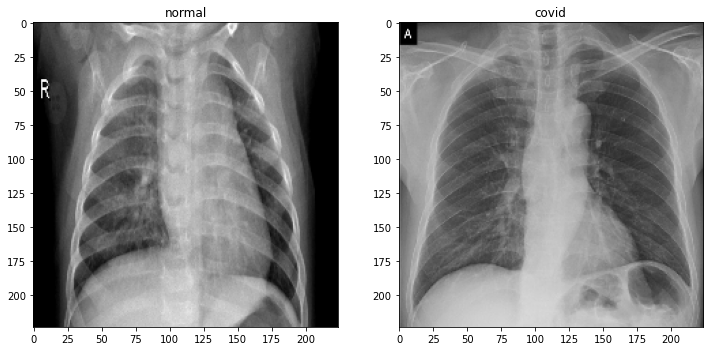

In [9]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(data[0])
plt.grid(False)
plt.title(labels[0])
plt.subplot(1,2,2)
plt.imshow(data[-1])
plt.title(labels[-1])
plt.grid(False)
plt.show()

## Preprocessing

Convert the data and labels to NumPy arrays while scaling the pixel intensities to the range $[0,1]$

In [10]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [11]:
labels

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid'], dtype='<U6')

Perform one-hot encoding on the labels:

In [12]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [13]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Split into training- and test-partition
Partition the data into training and testing splits using 60% of the data for training and the remaining 40% for testing

In [14]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.40, stratify=labels, random_state=42)

In [15]:
print(trainX.shape)
print(testX.shape)

(30, 224, 224, 3)
(20, 224, 224, 3)


## Image Data Generator

The [ImageDataGenerator](https://keras.io/api/preprocessing/image/) is an easy way to load and augment images in batches for image classification tasks. Together with the method `fit_generator()` (see below), it provides the possibility, that not all of the training data must be kept in the memory. Instead only the current batch is loaded. Moreover, the `ImageDataGenerator`-class provides methods to modify images, e.g. by shift, rotation, flipping, color-transform etc. 
In the code cell below an object of this class is instantiated, which will randomly rotate images within an angle of 15°.

In [17]:
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

## Load Feature Extractor Part of pretrained VGG16 Net

In [18]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

## Construct the new Classifier that will be placed on top of the Feature Extractor

In [34]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

Loop over all layers in the base model and freeze them so that they will **not** be updated during the training process

In [40]:
for layer in baseModel.layers:
    layer.trainable = False

In [41]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Compile and train Network

In [37]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [38]:
print("[INFO] training classifier part of the network...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    verbose=False,
    epochs=EPOCHS)

[INFO] training classifier part of the network...


/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


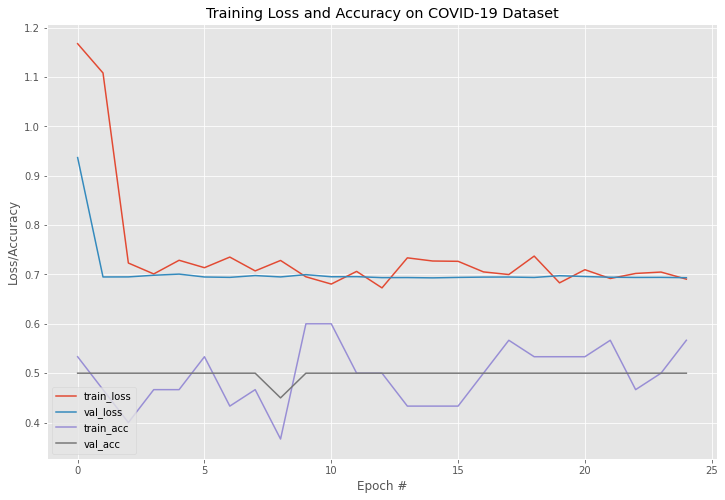

In [39]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")

## Evaluation

In [30]:
print("[INFO] Apply model on test data...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] Apply model on test data...


### Classification Report

In [31]:
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      0.90      0.95        10
      normal       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



### Confusion Matrix

In [32]:
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(8, 6)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() 

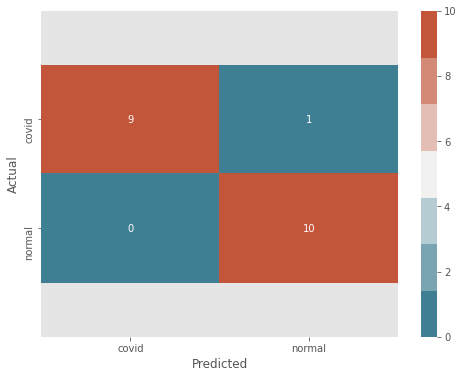

In [33]:
plot_cm(testY.argmax(axis=1), predIdxs, lb.classes_)